# Машинное обучение, ФКН ВШЭ

# Практическое задание 12. Несбалансированные задачи

## Общая информация
Дата выдачи: 26.04.2021

Мягкий дедлайн: 10.05.2021 00:59 MSK

Жёсткий дедлайн: 14.05.2021 00:59 MSK

## Субъективная оценка выполненного задания

Сделал все задания из первой части (от минус первого до третьего, 5 баллов), сделал бонусы (2.5 + непонятно что будет за недобитые 14 стотысячных в бонусе на качество метрик), во второй части пропустил реализацию класса, проверил IF, LOF, 1SVM и применил их результаты в качестве признаков (1.5 балла). Ещё рандомный бонус на 0.1. Ну и штраф на -4.

Получается 5 и ещё в случае доброты ассистента выйдет ещё +2.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [ ]:
%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open creditcardfraud.zip, creditcardfraud.zip.zip or creditcardfraud.zip.ZIP.


У меня не получилось прогнать ячейку с кодом выше, поэтому я решил сделать чуть-чуть по другому.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

У нас 492 случая совершения мошеннических операций, что явно меньше 284 тысяч немошеннических операций :)

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [4]:
df['Day'] = df['Time'] // (60*60*24)
df['Hour'] = (df['Time'] - df['Day']*60*60*24) // 3600

In [ ]:
df[['Day', 'Hour']]

,Day,Hour
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
284802,1.0,23.0
284803,1.0,23.0
284804,1.0,23.0
284805,1.0,23.0


Наши данные содержат в себе информацию о двух днях

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

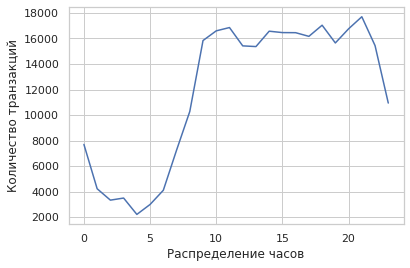

In [ ]:
ax = sns.lineplot(y=df['Hour'].value_counts().sort_index(), x=df['Hour'].unique())
ax.set(xlabel='Распределение часов', ylabel='Количество транзакций')
plt.show()

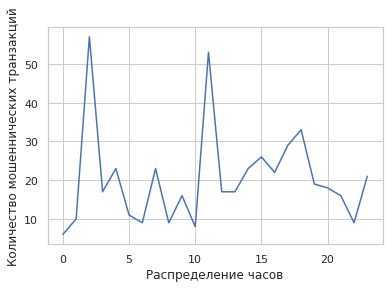

In [ ]:
ax = sns.lineplot(y=df[df['Class']==1]['Hour'].value_counts().sort_index(), x=df['Hour'][df['Class']==1].unique())
ax.set(xlabel='Распределение часов', ylabel='Количество мошеннических транзакций')
plt.show()

Видим, что в более ранние часы мы видим непропорционально больше мошеннических транзакций, чем утром. Следовательно, с большей долей вероятности в ранние часы может произойти операция подобного рода.

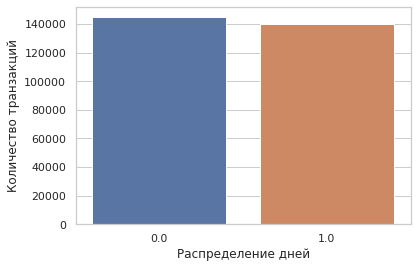

In [ ]:
ax = sns.barplot(y=df['Day'].value_counts().sort_index(), x=df['Day'].unique())
ax.set(xlabel='Распределение дней', ylabel='Количество транзакций')
plt.show()

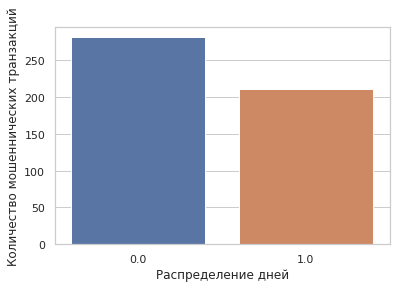

In [ ]:
ax = sns.barplot(y=df[df['Class']==1]['Day'].value_counts().sort_index(), x=df[df['Class']==1]['Day'].unique())
ax.set(xlabel='Распределение дней', ylabel='Количество мошеннических транзакций')
plt.show()

Вполне ожидаемо, в первый день мы видим значимо большее количество мошеннических операций. Таким образом, на основании 4 построенных графиков мы можем предположить следующее: чем больше времени прошло с первой транзакции, тем меньше вероятность того, что операция является мошеннической.

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Day,Hour
Time,1.000000,0.117396,-0.010593,-0.419618,-0.105260,0.173072,-0.063016,0.084714,-0.036949,-0.008660,0.030617,-0.247689,0.124348,-0.065902,-0.098757,-0.183453,0.011903,-0.073297,0.090438,0.028975,-0.050866,0.044736,0.144059,0.051142,-0.016182,-0.233083,-0.041407,-0.005135,-0.009413,-0.010596,-0.012323,0.896490,0.415575
V1,0.117396,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.227709,-0.101347,0.131838,-0.005214
V2,-0.010593,0.000000,1.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.531409,0.091289,-0.015474,0.007802
V3,-0.419618,-0.000000,0.000000,1.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.210880,-0.192961,-0.450604,-0.021569
V4,-0.105260,0.000000,-0.000000,-0.000000,1.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.098732,0.133447,-0.098590,-0.035063
V5,0.173072,0.000000,-0.000000,-0.000000,-0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.386356,-0.094974,0.207430,-0.035134
V6,-0.063016,0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.215981,-0.043643,-0.059994,-0.018945
V7,0.084714,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.397311,-0.187257,0.097864,-0.009729
V8,-0.036949,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.103079,0.019875,-0.056331,0.032106
V9,-0.008660,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.044246,-0.097733,0.083495,-0.189830


In [ ]:
df.corrwith(df['Class'])[abs(df.corrwith(df['Class']))>abs(np.median(df.corrwith(df['Class']))+np.std(df.corrwith(df['Class'])))]

V10     -0.216883
V12     -0.260593
V14     -0.302544
V17     -0.326481
Class    1.000000
dtype: float64

In [ ]:
df.corrwith(df['Class'])[abs(df.corrwith(df['Class']))>abs(np.median(df.corrwith(df['Class']))-np.std(df.corrwith(df['Class'])))]

V12     -0.260593
V14     -0.302544
V17     -0.326481
Class    1.000000
dtype: float64

Видим, что у нас есть четыре признака, наиболее коррелирующих с меткой класса. Посмотрим на их распределение в разных классах

In [7]:
names = np.array(['V10', 'V12', 'V14', 'V17'])

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(4*4, 4*2))
    for i in range(len(names)):
        plt.subplot(2, 2, i+1)
        plt.hist(X1.iloc[:, i], bins=bins, alpha=0.5, label=label1, color='C0', density=True)
        plt.hist(X2.iloc[:, i], bins=bins, alpha=0.5, label=label2, color='C1', density=True)
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()

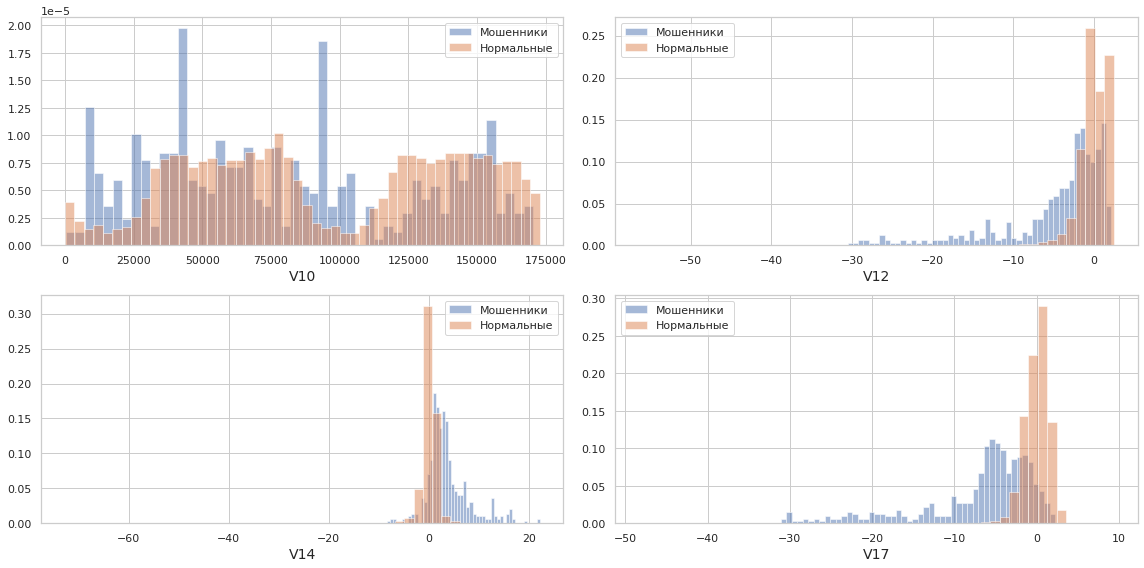

In [ ]:
plot_hists(df[df['Class']==1], df[df['Class']==0], names, label1="Мошенники", label2="Нормальные", bins=50)

В целом кажется, что компоненты 14 и 17 послужат достаточно хорошими индикаторами для распознавания мошеннической активности

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [5]:
#Возьмём первые 80% на обучение
df_train = df.head(int(len(df)*0.8))
#Объединим трейн с исходным датасетом для получения оставшейся части выборки
common = df.merge(df_train, on='Time')
#Получаем оставшиеся 20% выборки, исключив из рассмотрения все повторяющиеся в common наблюдения
df_testval = df[~df.Time.isin(common.Time)]
#Из оставшихся 20% выборки возьмём половину на валидацию
df_val = df_testval.head(int(len(df_testval)*0.5))
common = df_testval.merge(df_val, on='Time')
#Берём последние 10% на тест
df_test = df_testval[~df_testval.Time.isin(common.Time)]

In [10]:
print(df_train['Time'].min())
print(df_train['Time'].max())
print(df_val['Time'].min())
print(df_val['Time'].max())
print(df_test['Time'].min())
print(df_test['Time'].max())

0.0
145247.0
145248.0
157640.0
157641.0
172792.0


In [ ]:
print(len(df_train))
print(len(df_test))
print(len(df_val))
print(len(df_train)+len(df_test)+len(df_val))

227845
28481
28481
284807


Вроде бы всё нормально, никакие значения не упустили.

In [6]:
X_train = df_train.drop('Class', axis=1)
y_train = df_train['Class']
X_test = df_test.drop('Class', axis=1)
y_test = df_test['Class']
X_val = df_val.drop('Class', axis=1)
y_val = df_val['Class']

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

**На примере нашей задачи кажется, что точность наивного предсказания составит $\frac{284315}{284315+492}\approx0.9983$, вроде бы круто, но на самом деле совсем нет :)**

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [7]:
#А какой код мне здесь надо писать?
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, recall_score, precision_score, roc_curve

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [8]:
from sklearn.metrics import cohen_kappa_score

На наивном подходе должно получиться $\frac{0.998-(0.998*1+0.002*0)}{1-(0.998*1+0.002*0)}=\frac{0}{0.002}=0$

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [9]:
from sklearn.metrics import matthews_corrcoef

На наивном подходе должно получиться $\frac{0-0}{...}=0$

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [232]:
y = df['Class']
#Создадим пустую колонку
df['Naive'] = 0
#Найдём моду целевой переменной
mode = df['Class'].mode()
#заполним созданный столбец модой
df['Naive'] = df['Naive'].fillna(mode)
y_pred = df['Naive']

In [ ]:
y_pred

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Naive, Length: 284807, dtype: int64

In [17]:
precision, recall, thresholds = precision_recall_curve(y, y_pred)
auc(precision, recall)

0.49913625718468996

In [ ]:
cohen_kappa_score(y, y_pred)

0.0

In [233]:
matthews_corrcoef(y, y_pred)

0.0

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [ ]:
pip install catboost

In [11]:
from catboost import CatBoostClassifier

In [20]:
cb_clf = CatBoostClassifier()

In [ ]:
cb_clf.fit(X_train, y_train)
y_pred = cb_clf.predict(X_test)

In [12]:
def evaluate_metrics(y_test, y_pred):
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  pr_auc = auc(precision, recall)
  ck_score = cohen_kappa_score(y_test, y_pred)
  mc_score = matthews_corrcoef(y_test, y_pred)
  print("AUC-PR:", round(pr_auc, 5))
  print("Коэффициента Каппа-Коэна:", round(ck_score, 5))
  print("Коэффициент Меттьюза:", round(mc_score, 5))
  return

In [25]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.75505
Коэффициента Каппа-Коэна: 0.73667
Коэффициент Меттьюза: 0.74604


Кажется, что получились слишком большие значения метрик для базовых гиперпараметров, но я мучительно вглядывался в свой предыдущий код и так и не смог найти ошибку (разбиение вроде правильное, в датафрейме иксов нет меток классов, всё же хорошо...)

In [ ]:
params = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': [500]}
cb_clf.grid_search(params, X=X_val, y=y_val, plot=True)

In [ ]:
cb_clf = CatBoostClassifier(depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.1)
cb_clf.fit(X_train, y_train)
y_pred = cb_clf.predict(X_test)

In [27]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.72931
Коэффициента Каппа-Коэна: 0.71776
Коэффициент Меттьюза: 0.72374


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

Странно, я как-то очень плохо перебирал гиперпараметры, раз у меня качество метрик значимо ухудшилось. Короче говоря, значения несколько превосходят ожидаемые, но это, наверное, и хорошо.

Возможно, я как-то неверно понял AUC-PR, поэтому её значения получились несколько завышенными.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [28]:
pos_weight = (y_train.count()-y_train.sum())/y_train.sum()

In [29]:
imb_cb_clf = CatBoostClassifier(class_weights=[1, pos_weight])

In [ ]:
imb_cb_clf.fit(X_train, y_train)
y_pred = imb_cb_clf.predict(X_test)

In [31]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.72568
Коэффициента Каппа-Коэна: 0.72318
Коэффициент Меттьюза: 0.72466


Ура! Качество несколько увеличилось относительно бейзлайна! Но оказалось хуже, чем катбуст с базовыми гиперпараметрами...

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [32]:
imb_cb_clf = CatBoostClassifier(loss_function='Logloss', eval_metric='PRAUC:hints=skip_train~false', metric_period=200)

In [ ]:
params = {'class_weights': [[1, pos_weight], [1, pos_weight*0.1], [1, pos_weight*0.25], 
                            [1, pos_weight*0.5], [1, pos_weight*0.75], [1, pos_weight*0.9],
                            [1, pos_weight*0.95], [1, pos_weight*1.05], [1, pos_weight*1.1],
                            [1, pos_weight*1.25], [1, pos_weight*1.5], [1, 1]],
          'target_border': [0.1, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.998]}
imb_cb_clf.grid_search(params, X=X_val, y=y_val, plot=True)

In [42]:
best_imb_cb_clf = CatBoostClassifier(loss_function='Logloss', eval_metric='PRAUC:hints=skip_train~false', metric_period=200, 
                                     class_weights=[1.0, 545.3908872901678])

In [ ]:
params = {'target_border': [0.0001, 0.0002, 0.0005, 0.0009, 0.001, 0.0012, 0.0015, 0.0018]}
best_imb_cb_clf.grid_search(params, X=X_val, y=y_val, plot=True)

In [44]:
best_imb_cb_clf = CatBoostClassifier(loss_function='Logloss', eval_metric='PRAUC:hints=skip_train~false', metric_period=200, 
                                     class_weights=[1.0, 545.3908872901678], target_border=0.0001)

In [45]:
best_imb_cb_clf.fit(X_train, y_train)

Learning rate set to 0.104628
0:	learn: 0.9746062	total: 117ms	remaining: 1m 57s
200:	learn: 0.9999879	total: 18.4s	remaining: 1m 13s
400:	learn: 0.9999895	total: 32.3s	remaining: 48.2s
600:	learn: 0.9999904	total: 45.9s	remaining: 30.5s
800:	learn: 0.9999904	total: 59.3s	remaining: 14.7s
999:	learn: 0.9999904	total: 1m 12s	remaining: 0us


In [46]:
y_pred = best_imb_cb_clf.predict(X_test)

In [47]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.72568
Коэффициента Каппа-Коэна: 0.72318
Коэффициент Меттьюза: 0.72466


Странно, но почему-то после подбора гиперпараметров качество вообще никак не изменилось. Вроде бы, я всё делаю правильно и никаких грубых ошибок не совершил...

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [ ]:
!pip3 install imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [13]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [ ]:
oversampling = SMOTE()
X_train_os, y_train_os = oversampling.fit_resample(X_train, y_train)

In [54]:
cb_clf = CatBoostClassifier(depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.4693577	total: 206ms	remaining: 1m 42s
100:	learn: 0.0097340	total: 16.8s	remaining: 1m 6s
200:	learn: 0.0031748	total: 32.7s	remaining: 48.7s
300:	learn: 0.0015378	total: 48.3s	remaining: 31.9s
400:	learn: 0.0012079	total: 1m 1s	remaining: 15.3s
499:	learn: 0.0011723	total: 1m 14s	remaining: 0us


In [55]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.72661
Коэффициента Каппа-Коэна: 0.72706
Коэффициент Меттьюза: 0.72706


Все метрики обновили свой рекорд качества на несколько тысячных.

In [14]:
oversampling1_2 = SMOTE(sampling_strategy=0.5)
X_train_os, y_train_os = oversampling1_2.fit_resample(X_train, y_train)

In [15]:
cb_clf = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.4738172	total: 204ms	remaining: 3m 23s
100:	learn: 0.0100693	total: 12.9s	remaining: 1m 55s
200:	learn: 0.0034463	total: 25.1s	remaining: 1m 39s
300:	learn: 0.0015519	total: 37.2s	remaining: 1m 26s
400:	learn: 0.0010182	total: 48.3s	remaining: 1m 12s
500:	learn: 0.0009296	total: 58.3s	remaining: 58.1s
600:	learn: 0.0008052	total: 1m 8s	remaining: 45.4s
700:	learn: 0.0007856	total: 1m 18s	remaining: 33.7s
800:	learn: 0.0007852	total: 1m 29s	remaining: 22.3s
900:	learn: 0.0007849	total: 1m 40s	remaining: 11s
999:	learn: 0.0007618	total: 1m 50s	remaining: 0us


In [14]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.74392
Коэффициента Каппа-Коэна: 0.74399
Коэффициент Меттьюза: 0.74419


In [28]:
oversampling1_10 = SMOTE(sampling_strategy=0.1)
X_train_os, y_train_os = oversampling1_10.fit_resample(X_train, y_train)
cb_clf = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.4893043	total: 95.2ms	remaining: 1m 35s
100:	learn: 0.0082036	total: 9.43s	remaining: 1m 23s
200:	learn: 0.0031244	total: 18.5s	remaining: 1m 13s
300:	learn: 0.0012981	total: 27.6s	remaining: 1m 4s
400:	learn: 0.0007358	total: 36.4s	remaining: 54.3s
500:	learn: 0.0005108	total: 44.6s	remaining: 44.4s
600:	learn: 0.0004566	total: 52.2s	remaining: 34.6s
700:	learn: 0.0003933	total: 59.8s	remaining: 25.5s
800:	learn: 0.0003911	total: 1m 6s	remaining: 16.6s
900:	learn: 0.0003909	total: 1m 14s	remaining: 8.14s
999:	learn: 0.0003806	total: 1m 21s	remaining: 0us


In [29]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.80741
Коэффициента Каппа-Коэна: 0.79986
Коэффициент Меттьюза: 0.8039


Крайне любопытно, что при уменьшении количества синтетических мошеннических операций мы получаем всё более и более высокие показатели качества. Видимо, полное восстановление баланса делает наш датасет чересчур искусственным, что приводит к нахождению мнимых несуществующих связей (как и при соотношении 1/2).

В свою очередь, соотношение 1/10 почти позволило пробить один из бонусов этой домашки, что свидетельствует о вполне достойном  уделении внимания всем важным деталям несбалансированного класса. В бонусе возьмём такую реализацию как бейзлайн, для которого будем оптимизировать гиперпараметры обоих шагов.

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - суть этого метода в том, чтобы создавать новые синтетические наблюдения из минорного класса (всех кроме главного в общем случае) так, чтобы эти наблюдения находились вдоль разделяющих гиперплоскостей. Вполне логичная модификация в случае грамотного набора объясняющих признаков, которая помогает классификатору лучше определить границы. Однако тут может возникнуть серьёзная проблема с переобучением в случае неоднородности распределения минорного класса. [Визуализация работы модели](https://disk.yandex.ru/i/z6VKhh2NiiDYQg). [Ссылочка на статью](https://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf)

SVM-SMOTE - этот метод является надстройкой над Borderline SMOTE и отличается от заложенного в приведённом выше методе тем, что для обнаружения разделяющей гиперплоскости, вдоль которой создаются новые объекты, будет использован наш любимый метод опорных векторов, а не KNN, заложенный в Borderline. [Ссылочка на источник](https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5)

K-Means-SMOTE - этот метод работает в три шага: сначала происходит кластеризация исходного массива по принципу k-means, после чего каждому из кластеров выделяется определённый вес для оверсемплинга в зависимости от количества меток минорного кластера в нём. После этого для каждого кластера применяется обычный SMOTE. [Ссылочка на источник](https://github.com/felix-last/kmeans_smote/blob/master/kmeans_smote.py)

ADASYN - Adaptive Synthetic Sampling базируется на генерации синтетических данных в зависимости от распределения нашего минорного класса. Причём, как ни странно, зависимость обратно пропорциональная. То есть если на нашей гиперплоскости лежит одинокий представитель минорного класса, то метод нагенерит кучу похожих наблюдений в его окрестности. Очевидно, проблемой такого метода может стать наличие выбросов, которые наизнанку выворачивают возможные взаимосвязи в наших данных. [Ссылочка на источник](https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5)

Теперь попробуйте сравнить качество всех методов на наших данных.

In [16]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, ADASYN

In [ ]:
pip install -U imbalanced-learn

In [15]:
from imblearn.over_sampling import KMeansSMOTE

In [ ]:
Border = BorderlineSMOTE()
X_train_os, y_train_os = Border.fit_resample(X_train, y_train)

In [34]:
cb_clf = CatBoostClassifier(depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.3973341	total: 191ms	remaining: 1m 35s
100:	learn: 0.0012531	total: 16s	remaining: 1m 3s
200:	learn: 0.0010703	total: 29.4s	remaining: 43.7s
300:	learn: 0.0010492	total: 41.9s	remaining: 27.7s
400:	learn: 0.0010385	total: 54.5s	remaining: 13.5s
499:	learn: 0.0010383	total: 1m 7s	remaining: 0us


In [35]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.7108
Коэффициента Каппа-Коэна: 0.71088
Коэффициент Меттьюза: 0.71106


In [36]:
SVM = SVMSMOTE()
X_train_os, y_train_os = SVM.fit_resample(X_train, y_train)
cb_clf = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.2, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.2110951	total: 191ms	remaining: 3m 10s
100:	learn: 0.0010819	total: 14.8s	remaining: 2m 11s
200:	learn: 0.0010818	total: 28s	remaining: 1m 51s
300:	learn: 0.0010818	total: 41.4s	remaining: 1m 36s
400:	learn: 0.0010818	total: 54.6s	remaining: 1m 21s
500:	learn: 0.0010818	total: 1m 7s	remaining: 1m 7s
600:	learn: 0.0010818	total: 1m 21s	remaining: 53.8s
700:	learn: 0.0010818	total: 1m 34s	remaining: 40.2s
800:	learn: 0.0010818	total: 1m 47s	remaining: 26.7s
900:	learn: 0.0010814	total: 2m	remaining: 13.3s
999:	learn: 0.0010812	total: 2m 13s	remaining: 0us


In [37]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.72661
Коэффициента Каппа-Коэна: 0.72706
Коэффициент Меттьюза: 0.72706


Данный метод на базовых гиперпараметрах показал наилучший результат среди всех надстроек над SMOTE, повторив значения исходного SMOTE на базовых гиперпараметрах.

In [49]:
SVM = SVMSMOTE(sampling_strategy=0.1)
X_train_os, y_train_os = SVM.fit_resample(X_train, y_train)
cb_clf = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.2, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.2161552	total: 110ms	remaining: 1m 49s
100:	learn: 0.0009614	total: 8.9s	remaining: 1m 19s
200:	learn: 0.0003318	total: 17.6s	remaining: 1m 9s
300:	learn: 0.0002557	total: 25.1s	remaining: 58.3s
400:	learn: 0.0002556	total: 31.9s	remaining: 47.7s
500:	learn: 0.0002278	total: 39s	remaining: 38.9s
600:	learn: 0.0002188	total: 46.4s	remaining: 30.8s
700:	learn: 0.0002029	total: 54s	remaining: 23s
800:	learn: 0.0001903	total: 1m 1s	remaining: 15.3s
900:	learn: 0.0001788	total: 1m 9s	remaining: 7.58s
999:	learn: 0.0001787	total: 1m 16s	remaining: 0us


In [50]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.78402
Коэффициента Каппа-Коэна: 0.78033
Коэффициент Меттьюза: 0.78243


На "оптимальных" гиперпараметрах данный метод отработал хуже ванильного SMOTE.

In [20]:
KMeans = KMeansSMOTE(sampling_strategy=0.1, cluster_balance_threshold=0.001)
X_train_os, y_train_os = KMeans.fit_resample(X_train, y_train)
cb_clf = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.2, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.2257207	total: 162ms	remaining: 2m 41s
100:	learn: 0.0009710	total: 8.96s	remaining: 1m 19s
200:	learn: 0.0003547	total: 17.5s	remaining: 1m 9s
300:	learn: 0.0002491	total: 25.2s	remaining: 58.6s
400:	learn: 0.0002309	total: 32.7s	remaining: 48.9s
500:	learn: 0.0002304	total: 40.5s	remaining: 40.3s
600:	learn: 0.0002103	total: 48.2s	remaining: 32s
700:	learn: 0.0002081	total: 55.9s	remaining: 23.9s
800:	learn: 0.0002081	total: 1m 3s	remaining: 15.8s
900:	learn: 0.0002080	total: 1m 10s	remaining: 7.8s
999:	learn: 0.0002080	total: 1m 18s	remaining: 0us


In [21]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.80741
Коэффициента Каппа-Коэна: 0.79986
Коэффициент Меттьюза: 0.8039


Немножко пошаманив с гиперпараметрами для оверсемплинг-модели, мы получили тот же уровень качества, что и на обычном SMOTE. Классно? Вроде да

In [46]:
inv_dens = ADASYN()
X_train_os, y_train_os = inv_dens.fit_resample(X_train, y_train)

In [47]:
cb_clf = CatBoostClassifier(depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.4746883	total: 212ms	remaining: 1m 45s
100:	learn: 0.0101847	total: 17.1s	remaining: 1m 7s
200:	learn: 0.0035267	total: 33.3s	remaining: 49.6s
300:	learn: 0.0016701	total: 49.3s	remaining: 32.6s
400:	learn: 0.0013088	total: 1m 2s	remaining: 15.4s
499:	learn: 0.0012002	total: 1m 15s	remaining: 0us


In [48]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.6963
Коэффициента Каппа-Коэна: 0.69541
Коэффициент Меттьюза: 0.69607


Как и ожидалось, отсутствие обработанных выбросов привело к весьма низкому качеству модели.

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [22]:
from imblearn.under_sampling import RandomUnderSampler

In [23]:
RUS = RandomUnderSampler()
X_train_us, y_train_us = RUS.fit_resample(X_train, y_train)

In [ ]:
cb_clf = CatBoostClassifier(iterations=1000, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_us, y_train_us)
y_pred = cb_clf.predict(X_test)

In [30]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.40587
Коэффициента Каппа-Коэна: 0.07539
Коэффициент Меттьюза: 0.17463


Всё очень плохо

In [ ]:
sampling_strategy=[0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
AUC_PR = [0]*len(sampling_strategy)
KC = [0]*len(sampling_strategy)
Matt = [0]*len(sampling_strategy)
for i in range(len(sampling_strategy)):
  RUS = RandomUnderSampler(sampling_strategy=sampling_strategy[i])
  X_train_us, y_train_us = RUS.fit_resample(X_train, y_train)
  cb_clf = CatBoostClassifier(iterations=1000, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
  cb_clf.fit(X_train_us, y_train_us)
  y_pred = cb_clf.predict(X_test)
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  AUC_PR[i] = auc(precision, recall)
  KC[i] = cohen_kappa_score(y_test, y_pred)
  Matt[i] = matthews_corrcoef(y_test, y_pred)

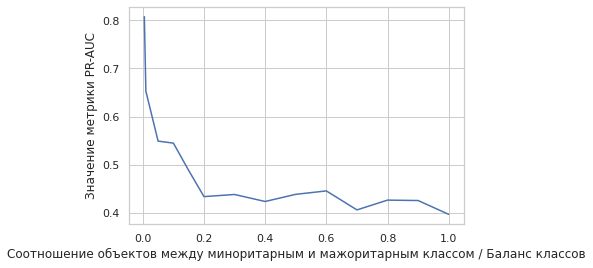

In [38]:
ax = sns.lineplot(y=AUC_PR, x=sampling_strategy)
ax.set(xlabel='Соотношение объектов между миноритарным и мажоритарным классом / Баланс классов', ylabel='Значение метрики PR-AUC')
plt.show()

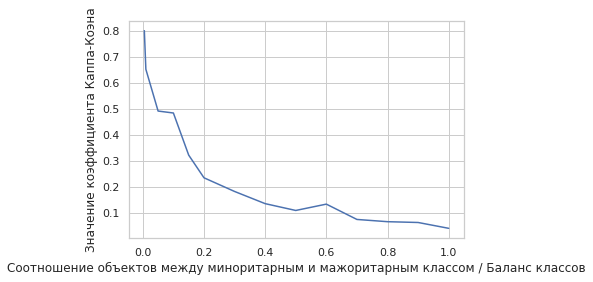

In [36]:
ax = sns.lineplot(y=KC, x=sampling_strategy)
ax.set(xlabel='Соотношение объектов между миноритарным и мажоритарным классом / Баланс классов', ylabel='Значение коэффициента Каппа-Коэна')
plt.show()

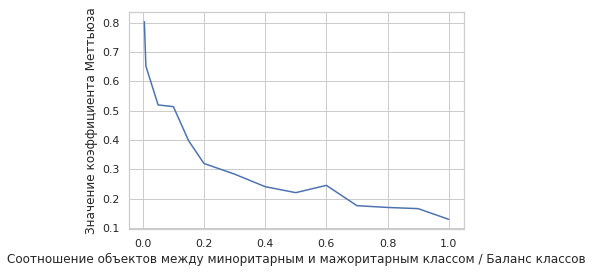

In [37]:
ax = sns.lineplot(y=Matt, x=sampling_strategy)
ax.set(xlabel='Соотношение объектов между миноритарным и мажоритарным классом / Баланс классов', ylabel='Значение коэффициента Меттьюза')
plt.show()

In [42]:
RUS = RandomUnderSampler(sampling_strategy=0.01)
X_train_us, y_train_us = RUS.fit_resample(X_train, y_train)

In [43]:
cb_clf = CatBoostClassifier(iterations=1000, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_us, y_train_us)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.4388863	total: 26.5ms	remaining: 26.5s
100:	learn: 0.0041345	total: 2.47s	remaining: 22s
200:	learn: 0.0014754	total: 4.9s	remaining: 19.5s
300:	learn: 0.0005747	total: 7.32s	remaining: 17s
400:	learn: 0.0003000	total: 9.71s	remaining: 14.5s
500:	learn: 0.0001833	total: 12.1s	remaining: 12.1s
600:	learn: 0.0001487	total: 14.4s	remaining: 9.53s
700:	learn: 0.0001365	total: 16.4s	remaining: 7s
800:	learn: 0.0001080	total: 18.7s	remaining: 4.64s
900:	learn: 0.0000961	total: 20.8s	remaining: 2.29s
999:	learn: 0.0000928	total: 22.8s	remaining: 0us


In [41]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.68297
Коэффициента Каппа-Коэна: 0.68059
Коэффициент Меттьюза: 0.68198


Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [ ]:
from imblearn.under_sampling import NearMiss

sampling_strategy = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_neighbors = [3, 4, 5, 6, 7, 10, 15]
AUC_PR = np.zeros(shape=(len(sampling_strategy), len(n_neighbors)))
KC = np.zeros(shape=(len(sampling_strategy), len(n_neighbors)))
Matt = np.zeros(shape=(len(sampling_strategy), len(n_neighbors)))
for i in range(len(sampling_strategy)):
  for j in range(len(n_neighbors)):
    NM = NearMiss(sampling_strategy=sampling_strategy[i], n_neighbors=n_neighbors[j])
    X_train_us, y_train_us = NM.fit_resample(X_train, y_train)
    cb_clf = CatBoostClassifier(iterations=1000, l2_leaf_reg=1, learning_rate=0.1, metric_period=1000)
    cb_clf.fit(X_train_us, y_train_us)
    y_pred = cb_clf.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    AUC_PR[i][j] = auc(precision, recall)
    KC[i][j] = cohen_kappa_score(y_test, y_pred)
    Matt[i][j] = matthews_corrcoef(y_test, y_pred)

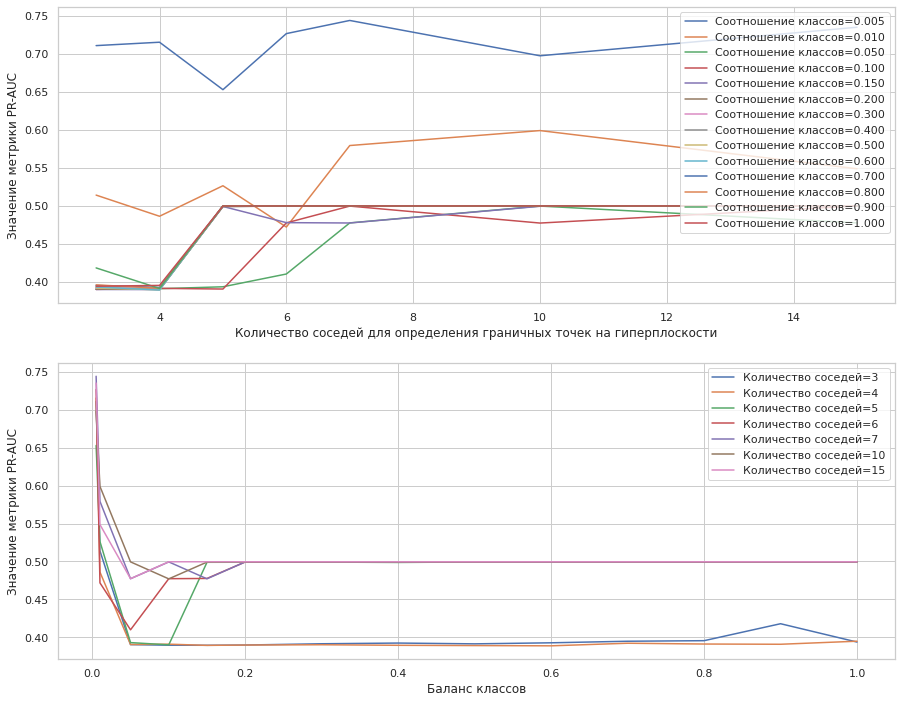

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

ax[0].set(xlabel='Количество соседей для определения граничных точек на гиперплоскости', ylabel='Значение метрики PR-AUC')
for i in sampling_strategy:
    ax[0].plot(n_neighbors, AUC_PR[sampling_strategy.index(i)], label="Соотношение классов=%.3f"%(i,))
ax[0].legend(loc='upper right')

ax[1].set(xlabel='Баланс классов', ylabel='Значение метрики PR-AUC')
for j in n_neighbors:
    ax[1].plot(sampling_strategy, AUC_PR[:, n_neighbors.index(j)], label="Количество соседей=%d"%(j,))
ax[1].legend(loc='upper right')

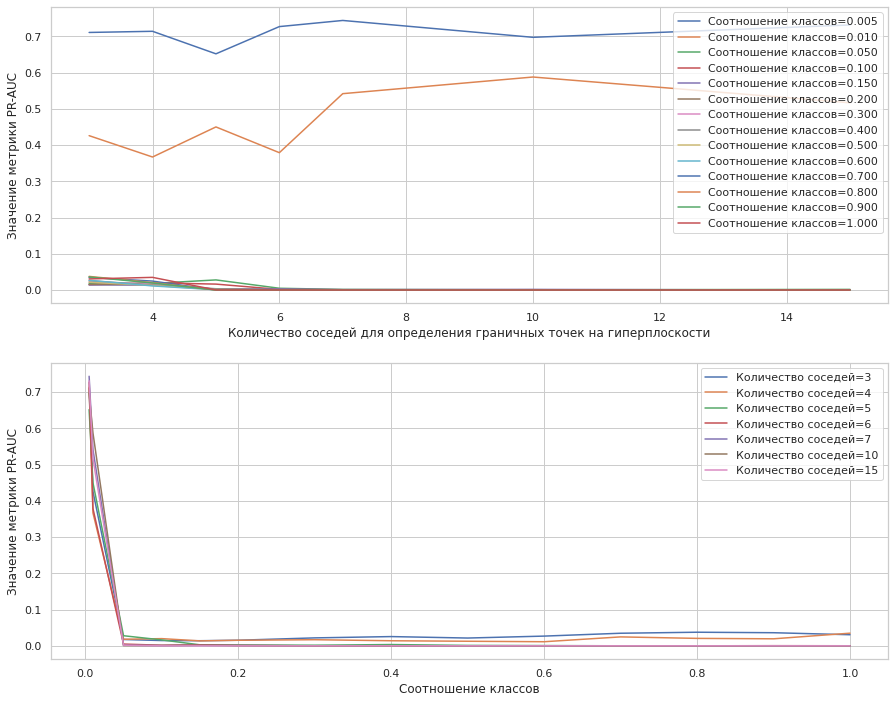

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

ax[0].set(xlabel='Количество соседей для определения граничных точек на гиперплоскости', ylabel='Значение метрики PR-AUC')
for i in sampling_strategy:
    ax[0].plot(n_neighbors, KC[sampling_strategy.index(i)], label="Соотношение классов=%.3f"%(i,))
ax[0].legend(loc='upper right')

ax[1].set(xlabel='Соотношение классов', ylabel='Значение метрики PR-AUC')
for j in n_neighbors:
    ax[1].plot(sampling_strategy, KC[:, n_neighbors.index(j)], label="Количество соседей=%d"%(j,))
ax[1].legend(loc='upper right')

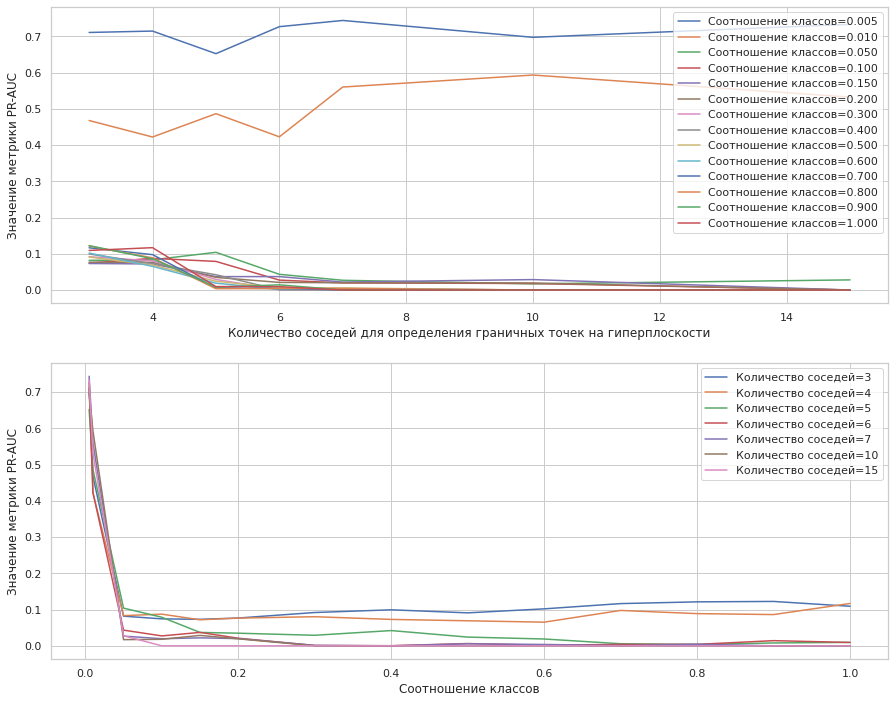

In [61]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

ax[0].set(xlabel='Количество соседей для определения граничных точек на гиперплоскости', ylabel='Значение метрики PR-AUC')
for i in sampling_strategy:
    ax[0].plot(n_neighbors, Matt[sampling_strategy.index(i)], label="Соотношение классов=%.3f"%(i,))
ax[0].legend(loc='upper right')

ax[1].set(xlabel='Соотношение классов', ylabel='Значение метрики PR-AUC')
for j in n_neighbors:
    ax[1].plot(sampling_strategy, Matt[:, n_neighbors.index(j)], label="Количество соседей=%d"%(j,))
ax[1].legend(loc='upper right')

Видим, что наиболее высокое качество классификации получается при соотношении количества наблюдений из миноритарного класса к мажоритарному, равном 0.005 и 0.1, тогда как количество соседей следует выбирать равным 3 (может быть ещё 15, но там только на PR-AUC норм качество). Также, глядя на эти графики, мы можем заметить, что качество получаемых оценок в NearMiss не превосходит лучшие модели для оверсемплинга.

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

Instance hardness threshold - метод подбора порога "жёсткости" для наблюдений, в соответствии с которым сначала на ансамбле из n классификаторов, для каждого из которых считается точность классификации. Среднее от точностей классификации для каждого из наблюдений является правдоподобием оценки, p. В таком случае 1-p называется порогом жёсткости, а наш метод IHT будет отбрасывать из рассмотрения наиболее сложные для классификации наблюдения. 

По сути, это аналог Borderline-SMOTE для андерсемплинга, при котором мы будем удалять все объекты из мажоритарного класса, лежащие вдоль разделяющей гиперплоскости. Вроде не такая уж и плохая идея...
[Ссылка на источник](https://towardsdatascience.com/instance-hardness-threshold-an-undersampling-method-to-tackle-imbalanced-classification-problems-6d80f91f0581)

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import InstanceHardnessThreshold
iht = InstanceHardnessThreshold(random_state=0, cv=3, sampling_strategy=0.05, estimator=KNeighborsClassifier())

In [82]:
X_train_us, y_train_us = iht.fit_resample(X_train, y_train)

In [83]:
cb_clf = CatBoostClassifier(iterations=1000, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_us, y_train_us)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.3757569	total: 104ms	remaining: 1m 43s
100:	learn: 0.0012834	total: 8.39s	remaining: 1m 14s
200:	learn: 0.0007006	total: 16.7s	remaining: 1m 6s
300:	learn: 0.0003098	total: 25.1s	remaining: 58.2s
400:	learn: 0.0001406	total: 33.4s	remaining: 49.9s
500:	learn: 0.0000801	total: 41.8s	remaining: 41.6s
600:	learn: 0.0000542	total: 50.1s	remaining: 33.2s
700:	learn: 0.0000403	total: 58.3s	remaining: 24.8s
800:	learn: 0.0000323	total: 1m 6s	remaining: 16.5s
900:	learn: 0.0000268	total: 1m 14s	remaining: 8.13s
999:	learn: 0.0000237	total: 1m 21s	remaining: 0us


In [84]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.75505
Коэффициента Каппа-Коэна: 0.73667
Коэффициент Меттьюза: 0.74604


Из опробованных методов андерсемплинга, этот кажется одним из наиболее качественных, но он слишком долго строит прогнозы для своей композиции классификаторов, по которым отсекает наиболее сложно-идентифицируемые объекты мажорного класса.

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

In [87]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [90]:
paramters = {
    'learning_rate': [0.3, 0.2, 0.1, 0.075, 0.05],
    'max_depth': [1, 3, 5, 7]
    }
xg_gs = GridSearchCV(xgb.XGBClassifier(), paramters, verbose=3, scoring='f1_weighted')

In [ ]:
xg_gs.fit(X_val, y_val)

In [92]:
xg_gs.best_params_

{'learning_rate': 0.2, 'max_depth': 7}

In [93]:
oversampling1_10 = SMOTE(sampling_strategy=0.1)
X_train_os, y_train_os = oversampling1_10.fit_resample(X_train, y_train)
xg_clf = xgb.XGBClassifier(learning_rate=0.2, max_depth=7, verbose=3, scoring='f1_weighted')
xg_clf.fit(X_train_os, y_train_os)
y_pred = xg_clf.predict(X_test)
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.68297
Коэффициента Каппа-Коэна: 0.68059
Коэффициент Меттьюза: 0.68198


Видимо, я подобрал плохие параметры для xgboost, вернёмся к катбусту

In [104]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [105]:
from imblearn.pipeline import Pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [106]:
X_train_os, y_train_os = pipeline.fit_resample(X_train, y_train)
cb_clf = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.2, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.3510911	total: 38.7ms	remaining: 38.7s
100:	learn: 0.0034263	total: 3.57s	remaining: 31.8s
200:	learn: 0.0011511	total: 6.7s	remaining: 26.6s
300:	learn: 0.0011505	total: 9.46s	remaining: 22s
400:	learn: 0.0011501	total: 12.2s	remaining: 18.3s
500:	learn: 0.0011494	total: 15s	remaining: 14.9s
600:	learn: 0.0010762	total: 17.8s	remaining: 11.8s
700:	learn: 0.0010594	total: 20.5s	remaining: 8.75s
800:	learn: 0.0010591	total: 23.3s	remaining: 5.78s
900:	learn: 0.0010588	total: 26s	remaining: 2.86s
999:	learn: 0.0010218	total: 28.7s	remaining: 0us


In [107]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.63883
Коэффициента Каппа-Коэна: 0.62712
Коэффициент Меттьюза: 0.63313


Комбинация овер- и андер-семплинга не дала хорошего результата

In [117]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(), sampling_strategy='auto', replacement=False, random_state=0)
brf_clf.fit(X_train, y_train)  
y_pred = brf_clf.predict(X_test)

In [118]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.40693
Коэффициента Каппа-Коэна: 0.07922
Коэффициент Меттьюза: 0.17926


Перебрав предложенные библиотекой imblearn ансамбли, я не получил ни одного результата с хотя бы приближенно нормальными значениями метрик.

In [120]:
sampling_strategy=[0.005, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
KC = [0]*len(sampling_strategy)
for i in range(len(sampling_strategy)):
  oversampling = SMOTE(sampling_strategy=sampling_strategy[i])
  X_train_us, y_train_us = oversampling.fit_resample(X_val, y_val)
  cb_clf = CatBoostClassifier(iterations=500, l2_leaf_reg=1, learning_rate=0.1, metric_period=250)
  cb_clf.fit(X_train_us, y_train_us)
  y_pred = cb_clf.predict(X_test)
  KC[i] = cohen_kappa_score(y_test, y_pred)

0:	learn: 0.4208763	total: 20.4ms	remaining: 10.2s
250:	learn: 0.0000417	total: 4.88s	remaining: 4.84s
499:	learn: 0.0000341	total: 8.95s	remaining: 0us
0:	learn: 0.3962135	total: 20.2ms	remaining: 10.1s
250:	learn: 0.0000469	total: 4.77s	remaining: 4.74s
499:	learn: 0.0000388	total: 8.87s	remaining: 0us
0:	learn: 0.4265667	total: 21.9ms	remaining: 10.9s
250:	learn: 0.0001416	total: 4.68s	remaining: 4.64s
499:	learn: 0.0001416	total: 8.81s	remaining: 0us
0:	learn: 0.4353600	total: 22.4ms	remaining: 11.2s
250:	learn: 0.0001732	total: 4.76s	remaining: 4.72s
499:	learn: 0.0001608	total: 8.96s	remaining: 0us
0:	learn: 0.4359175	total: 22.9ms	remaining: 11.5s
250:	learn: 0.0001864	total: 4.85s	remaining: 4.81s
499:	learn: 0.0001790	total: 9.03s	remaining: 0us
0:	learn: 0.4451469	total: 22.7ms	remaining: 11.3s
250:	learn: 0.0002551	total: 4.82s	remaining: 4.78s
499:	learn: 0.0001957	total: 9.23s	remaining: 0us
0:	learn: 0.4283124	total: 22.6ms	remaining: 11.3s
250:	learn: 0.0002278	total: 4.

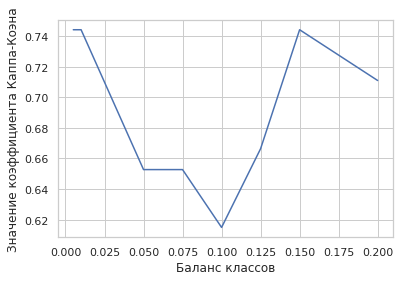

In [130]:
ax = sns.lineplot(y=KC, x=sampling_strategy)
ax.set(xlabel='Баланс классов', ylabel='Значение коэффициента Каппа-Коэна')
plt.show()

In [131]:
oversampling1_10 = SMOTE(sampling_strategy=0.01)
X_train_os, y_train_os = oversampling1_10.fit_resample(X_train, y_train)
cb_clf = CatBoostClassifier(depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.15, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.3184941	total: 95.9ms	remaining: 47.8s
100:	learn: 0.0018892	total: 8.48s	remaining: 33.5s
200:	learn: 0.0005109	total: 17s	remaining: 25.2s
300:	learn: 0.0001990	total: 25.4s	remaining: 16.8s
400:	learn: 0.0001340	total: 33s	remaining: 8.14s
499:	learn: 0.0001209	total: 39.6s	remaining: 0us


In [132]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.80741
Коэффициента Каппа-Коэна: 0.79986
Коэффициент Меттьюза: 0.8039


Какие бы гиперпараметры и соотношения сбалансированности классов я не подбирал, везде встречаю один и тот же результат... Даже не знаю, что уже можно сделать, чтобы улучшить качество и пробить этот бонус

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [ ]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])
    for i in  range(X.shape[0]):
            h_temp = 0
            for j in range(depth):
                h_temp += PathFactor(X[i],node[j]).path*1.0            # Compute path length for each point
            Eh = h_temp/depth                                             # Average of path length travelled by the point in all trees.
            scores[i] = 2.0**(-Eh)                                            # Anomaly Score
    return scores

class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        if depth >= 1 or X.shape[0] <=1:
          left = None
          right = None
          self.exnodes += 1
          return Node(X, depth, left, right, kind = 'external', None, None)
        else:                                                                   # Building the tree continues. All these nodes are internal.
            mins = X.min(axis=0)
            maxs = X.max(axis=0)
            idxs = np.random.choice(range(self.dim), self.dim-self.exlevel-1, replace=False)  # Pick the indices for which the normal vector elements should be set to zero acccording to the extension level.
            self.w = np.random.normal(0,1,self.dim)                             # A random normal vector picked form a uniform n-sphere. Note that in order to pick uniformly from n-sphere, we need to pick a random normal for each component of this vector.
            self.w[idxs] = 0
            self.b = np.random.uniform(mins,maxs)                               # Picking a random intercept point for the hyperplane splitting data.
            w = (X-self.p).dot(self.n) < 0                                      # Criteria that determines if a data point should go to the left or right child node.
            return Node(X, depth, left=self.grow(X[w],depth+1),
                        right=self.grow(X[~w],depth+1), kind = 'internal', self.w, self.b)
            
    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        scores = np.zeros(X.shape[0])
        for i in  range(X.shape[0]):
            h_temp = 0
            for j in range(depth):
                h_temp += PathFactor(X[i],node[j]).path*1.0            # Compute path length for each point
            Eh = h_temp/depth                                             # Average of path length travelled by the point in all trees.
            scores[i] = 2.0**(-Eh)                                            # Anomaly Score
        return scores        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        #your code here
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        #your code here

        return scores

    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        #your code here

        return labels


Я пытался подстроить под наши обозначения код, ссылка на который лежала в предложенной для ознакомления с EIF статье, но что-то как-то всё пошло не так

In [214]:
pip install git+https://github.com/sahandha/eif.git

  Cloning https://github.com/sahandha/eif.git to /tmp/pip-req-build-7ft6gvcs
  Running command git clone -q https://github.com/sahandha/eif.git /tmp/pip-req-build-7ft6gvcs
  Created wheel for eif: filename=eif-2.0.2-cp37-cp37m-linux_x86_64.whl size=251579 sha256=8770af315312ecbb335aa78570cbaf556d5661109bae4dbd16c2a12cbc22ab43
  Stored in directory: /tmp/pip-ephem-wheel-cache-m29lvjfe/wheels/df/cc/a9/b9196f867030c85c26e87d09f1d5789dc119338f42d0ef37db
Successfully built eif


In [222]:
import eif
indus_model = eif.iForest(np.array(X_train), ntrees=200, sample_size=256, ExtensionLevel=0)
X_train_paths = indus_model.compute_paths(np.array(X_train))

In [223]:
X_test_paths = indus_model.compute_paths(np.array(X_test))

In [225]:
from sklearn.linear_model import LinearRegression
lr = LogisticRegression().fit(X_train_paths.reshape(-1, 1), y_train)
y_pred = lr.predict(X_test_paths.reshape(-1, 1))

In [231]:
pd.Series(y_pred).value_counts()

0    28480
1        1
dtype: int64

Нормально обучить модель индуса тоже не получилось :(

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [161]:
from sklearn.ensemble import IsolationForest
sk_IF = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.02,
                      max_features=.8, bootstrap=False, n_jobs=-1, random_state=0,
                      verbose=0)
sk_IF.fit(X_train[y_train==0])
y_pred = sk_IF.predict(X_test)

In [162]:
y_pred = np.where(y_pred==1, 0, y_pred)
y_pred = np.where(y_pred==-1, 1, y_pred)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [163]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.28095
Коэффициента Каппа-Коэна: 0.03274
Коэффициент Меттьюза: 0.09499


Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [212]:
#Делал пункты этой части непоследовательно, X_test['if'] - это оценки IF-метода
X_test[y_pred==1]['if']

258403   -0.627181
261056   -0.520825
261473   -0.533367
261925   -0.521188
262560   -0.599686
262826   -0.597805
263274   -0.600860
263324   -0.612046
263877   -0.606619
268375   -0.601360
274468   -0.503697
274475   -0.498720
276864   -0.541263
279863   -0.568170
280143   -0.514077
280149   -0.499344
281144   -0.595089
Name: if, dtype: float64

In [210]:
np.mean(X_test[y_pred==0]['if'])

-0.42979103228645094

In [211]:
np.mean(X_test[y_pred==1]['if'])

-0.5612528402604848

Вроде бы оценки не слишком большие, средние значения отличаются не столь сильно как могли бы.. Аа, наверное тут предполагалось, что "ваш" алгоритм - это тот, который я реализовал сам, но я его не реализовал...

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [174]:
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(leaf_size=50, novelty=True)
LOF.fit(X_train[y_train==0])
y_pred = LOF.predict(X_test)

In [175]:
y_pred = np.where(y_pred==1, 0, y_pred)
y_pred = np.where(y_pred==-1, 1, y_pred)

In [176]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.49961
Коэффициента Каппа-Коэна: 0.0
Коэффициент Меттьюза: 0.0


In [168]:
from sklearn.svm import OneClassSVM
SVM = OneClassSVM(nu=0.002)
SVM.fit(X_train[y_train==0])
y_pred = SVM.predict(X_test)

In [169]:
y_pred = np.where(y_pred==1, 0, y_pred)
y_pred = np.where(y_pred==-1, 1, y_pred)

In [170]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.49961
Коэффициента Каппа-Коэна: 0.0
Коэффициент Меттьюза: 0.0


У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [188]:
X_train_if = sk_IF.fit(X_train[y_train==0]).score_samples(X_train)
X_test_if = sk_IF.score_samples(X_test)

In [189]:
X_train_svm = SVM.fit(X_train[y_train==0]).score_samples(X_train)
X_test_svm = SVM.score_samples(X_test)

In [179]:
X_train_nof = LOF.negative_outlier_factor_
X_test_nof = LOF.fit(X_test).negative_outlier_factor_

In [190]:
np.corrcoef(X_train_if, X_train_svm)

array([[ 1.        , -0.09961792],
       [-0.09961792,  1.        ]])

In [ ]:
np.corrcoef(X_train_if, X_train_nof)

В local outlier factor нельзя узнать значения факторов без их фиттинга в модель, поэтому, видимо, придётся обойти без признаков из этого метода. Можно было бы конечно заполнить мошеннические транзакции в трейне средним по мошенническим транзакциям в тесте (это значение мы можем получить), но мне кажется, что смысла в этом маловато и это не улучшит модель несбалансированной классификации на порядок.

In [194]:
X_train['svm'] = X_train_svm
X_test['svm'] = X_test_svm
X_train['if'] = X_train_if
X_test['if'] = X_test_if

In [195]:
X_val_svm = SVM.score_samples(X_val)
X_val_if = sk_IF.score_samples(X_val)

In [196]:
X_val['svm'] = X_val_svm
X_val['if'] = X_val_if

In [ ]:
sampling_strategy=[0.005, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]
KC = [0]*len(sampling_strategy)
for i in range(len(sampling_strategy)):
  oversampling = SMOTE(sampling_strategy=sampling_strategy[i])
  X_train_us, y_train_us = oversampling.fit_resample(X_val, y_val)
  cb_clf = CatBoostClassifier(iterations=500, l2_leaf_reg=1, learning_rate=0.1, metric_period=250)
  cb_clf.fit(X_train_us, y_train_us)
  y_pred = cb_clf.predict(X_test)
  KC[i] = cohen_kappa_score(y_test, y_pred)

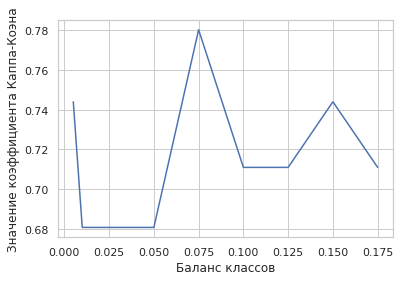

In [198]:
ax = sns.lineplot(y=KC, x=sampling_strategy)
ax.set(xlabel='Баланс классов', ylabel='Значение коэффициента Каппа-Коэна')
plt.show()

In [201]:
oversampling1_10 = SMOTE(sampling_strategy=0.075)
X_train_os, y_train_os = oversampling1_10.fit_resample(X_train, y_train)
cb_clf = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, metric_period=100)
cb_clf.fit(X_train_os, y_train_os)
y_pred = cb_clf.predict(X_test)

0:	learn: 0.4696165	total: 96ms	remaining: 1m 35s
100:	learn: 0.0074749	total: 9.28s	remaining: 1m 22s
200:	learn: 0.0025585	total: 18.5s	remaining: 1m 13s
300:	learn: 0.0010564	total: 27.6s	remaining: 1m 4s
400:	learn: 0.0005313	total: 36.6s	remaining: 54.7s
500:	learn: 0.0004427	total: 44.3s	remaining: 44.1s
600:	learn: 0.0004103	total: 51.7s	remaining: 34.3s
700:	learn: 0.0003569	total: 59.8s	remaining: 25.5s
800:	learn: 0.0003438	total: 1m 7s	remaining: 16.8s
900:	learn: 0.0003404	total: 1m 14s	remaining: 8.22s
999:	learn: 0.0003402	total: 1m 22s	remaining: 0us


In [202]:
evaluate_metrics(y_test, y_pred)

AUC-PR: 0.83356
Коэффициента Каппа-Коэна: 0.82039
Коэффициент Меттьюза: 0.82723


Ого! Качество улучшилось на порядок. Я надеюсь, что это улучшение будет зачтено в качестве бонуса за достижение 0.8 на всех метриках.

**Бонус. (0.5 балла).**

Ну что ж, вот и подошла к концу домашка по методам борьбы с несбалансированными данными. Надеемся, вы не сильно устали и вам еще не противно. А знаете, чье творчество тоже нельзя назвать сбалансированным? В течение своей жизни Роберт Фальк писал в самых разных жанрах, то ломая все традиции, то, наоборот, продвигая их в массы. В связи с этим мы рекомендуем ознакомиться с его работами на [выставке](https://www.tretyakovgallery.ru/exhibitions/robert-falk/) в Новой Третьяковке. Там вы сможете пронаблюдать весь творческий путь одного из знаковых советских живописцев.

Данный номер будет зачтен, если вы предоставите небольшой фотоотчет и расскажете, что вам удалось понять после посещения экспозиции.

Не успел после возвращения в Москву запланировать поездку в Новую Третьяковку, утонув в дедлайнах :(

Надеюсь, подобные бонусы будут и в следующих домашках!


**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. Если вы получите ровно 0, то мы посчитаем вас невероятно везучим человеком и в качестве поощрения зачтем теорминимум на коллоквиуме. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [160]:
import numpy as np

np.random.randn()

0.6688805048713475